In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
import os

root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data')

save_path = os.path.join(data_dir, 'assets_info.csv')

## Assets selection

I decided to choose 200 random assets from Yahoo Finance.

In [57]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv', 
    header=None,
    # error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4])

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


In [58]:
import random
n_assets = 200
n_assets_extra = 100 # just in case for some assets information is not available
random.seed(0)

assets = random.choices(all_tickers, k=n_assets + n_assets_extra)

In [59]:
assets[:10], len(assets)

(['X', 'SRC', 'HRL', 'DMS', 'MSGE', 'HR', 'TAK', 'ERF', 'KRG', 'NOA'], 300)

In [60]:
# save assets list to a file
with open(os.path.join(data_dir, 'assets.txt'), 'w') as f:
    for asset in assets:
        f.write(asset + '\n')

In [61]:
assets[:10]

['X', 'SRC', 'HRL', 'DMS', 'MSGE', 'HR', 'TAK', 'ERF', 'KRG', 'NOA']

## Downloading the data

In [62]:
import yfinance as yf
from tqdm import tqdm

In [63]:
data = yf.download('AAPL', period='6mo', interval='1h')
data.Close.values[:10]

[*********************100%***********************]  1 of 1 completed


array([174.16999817, 174.81500244, 174.6269989 , 173.90499878,
       174.3500061 , 175.44000244, 175.08999634, 169.91000366,
       170.61000061, 170.78500366])

In [64]:
def get_info(short_name):
    info_keys = ['symbol', 'sector', 'industry', 'country']
    info_values = []
    try:
        ticker = yf.Ticker(short_name)
    except:
        return {key: None for key in info_keys}
    for key in info_keys:
        info_values.append(ticker.info[key])
    return dict(zip(info_keys, info_values))

get_info('X')

{'symbol': 'X',
 'sector': 'Basic Materials',
 'industry': 'Steel',
 'country': 'United States'}

In [83]:
is_already_downloaded = os.path.exists(save_path)

if is_already_downloaded:
    assets_info = pd.read_csv(save_path)
else:
    full_ticker_data = []

    n_skip = 0
    for ticker in tqdm(assets):
        try:
            info = get_info(ticker)
            data = yf.download(ticker, period='6mo', interval='1h', progress=False)
            if len(data) == 0:
                n_skip += 1
                continue
            info['data'] = data.Close.to_dict()
            full_ticker_data.append(info)
        except:
            n_skip += 1
            continue

    print(f"Skipped {n_skip} tickers")
    assert n_skip < n_assets_extra, f"Too many tickers are skipped ({n_skip} out of {n_assets_extra})"
    full_ticker_data = full_ticker_data[:n_assets]
    assets_info = pd.DataFrame(full_ticker_data)

100%|██████████| 300/300 [02:03<00:00,  2.43it/s]

Skipped 79 tickers


In [84]:
assets_info.head()

,symbol,sector,industry,country,data
0,X,Basic Materials,Steel,United States,"{2024-03-04 09:30:00-05:00: 47.45000076293945,..."
1,HRL,Consumer Defensive,Packaged Foods,United States,{2024-03-04 09:30:00-05:00: 33.505001068115234...
2,MSGE,Consumer Cyclical,Leisure,United States,"{2024-03-04 09:30:00-05:00: 38.47999954223633,..."
3,HR,Real Estate,REIT - Healthcare Facilities,United States,{2024-03-04 09:30:00-05:00: 13.694999694824219...
4,TAK,Healthcare,Drug Manufacturers - Specialty & Generic,Japan,{2024-03-04 09:30:00-05:00: 14.449999809265137...


<Axes: >

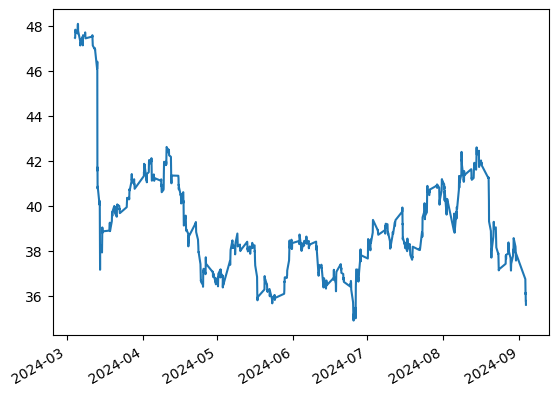

In [85]:
pd.Series(assets_info.at[0, 'data']).plot()

In [88]:
# count nans
assets_info.isna().sum()

symbol      0
sector      0
industry    0
country     0
data        0
dtype: int64

In [89]:
len(assets_info)

200

In [86]:
assets_info.to_csv(save_path, index=False)